In [1]:
import argparse
import subprocess
import sys
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import scipy
import SimpleITK as sitk

In [2]:
chunk_mask = sitk.ReadImage("reference_chunk_mask.nii.gz")[:, :, 0]
print(chunk_mask.GetSize())

(858, 1000)


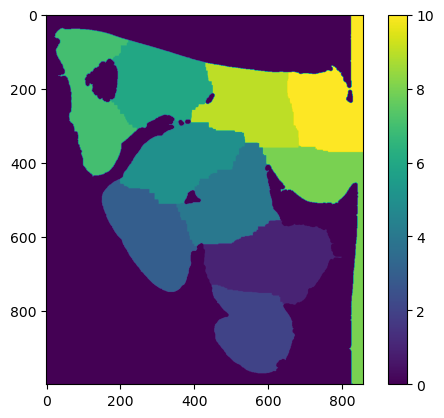

In [3]:
chunk_mask_arr = sitk.GetArrayFromImage(chunk_mask)

plt.imshow(chunk_mask_arr)
plt.colorbar()
plt.show()

(1000, 858)


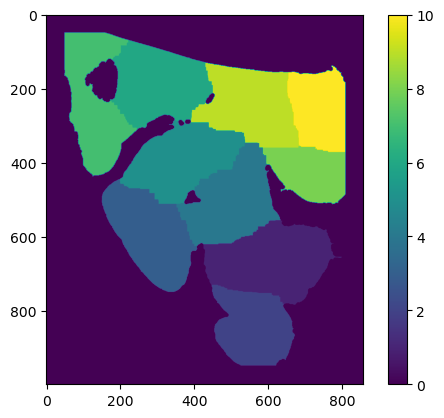

In [4]:
# The border of the chunk mask will give wrong results
# Replace 50 pixels along all borders with value 0
chunk_mask_arr[:50, :] = 0
chunk_mask_arr[-50:, :] = 0
chunk_mask_arr[:, :50] = 0
chunk_mask_arr[:, -50:] = 0

chunk_mask = sitk.GetImageFromArray(chunk_mask_arr)

print(chunk_mask_arr.shape)
plt.imshow(chunk_mask_arr)
plt.colorbar()

In [5]:
# Get all unique chunk labels
chunk_ids = np.unique(chunk_mask_arr)
# Remove the background label
chunk_ids = chunk_ids[chunk_ids != 0]

print(chunk_ids)

[ 1  2  3  4  5  6  7  8  9 10]


In [6]:
def chunk_dist_map(k):
    # Get the distance of every pixel from the boundary of the chunk with label k
    mask = sitk.BinaryThreshold(chunk_mask, int(k), int(k), 1, 0) # Extract only the chunk with label k
    return sitk.SignedDanielssonDistanceMap(mask, insideIsPositive=False, squaredDistance=True)

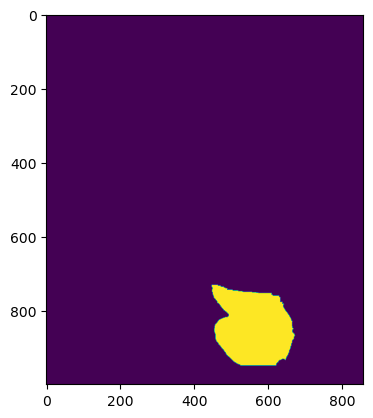

In [7]:
# Extract only the chunk with label k
k = 2
mask = sitk.BinaryThreshold(chunk_mask, int(k), int(k), 1, 0)
plt.imshow(sitk.GetArrayFromImage(mask))


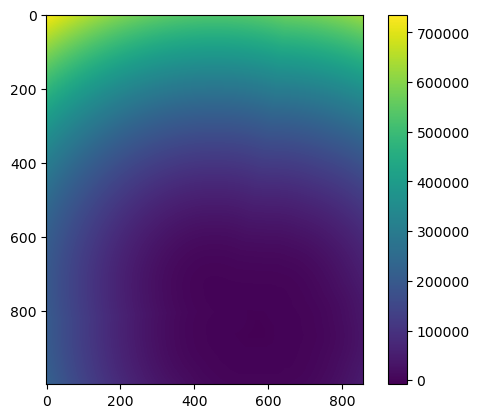

In [8]:
chunk_dist_map_k = sitk.SignedDanielssonDistanceMap(mask, insideIsPositive=False, squaredDistance=True)
plt.imshow(sitk.GetArrayFromImage(chunk_dist_map_k))
plt.colorbar()

In [9]:
# Get a list of distance masks for all chunks
# Dictionary with key as chunk id and value as distance map
dist_cmask = { k: chunk_dist_map(k) for k in chunk_ids }
# Convert the distance maps to numpy arrays
dist_arr = np.array([ dist_cmask[k] for k in chunk_ids ])

# Array of shape (n_chunks, width*height)
print(dist_arr.shape)

(10, 858000)


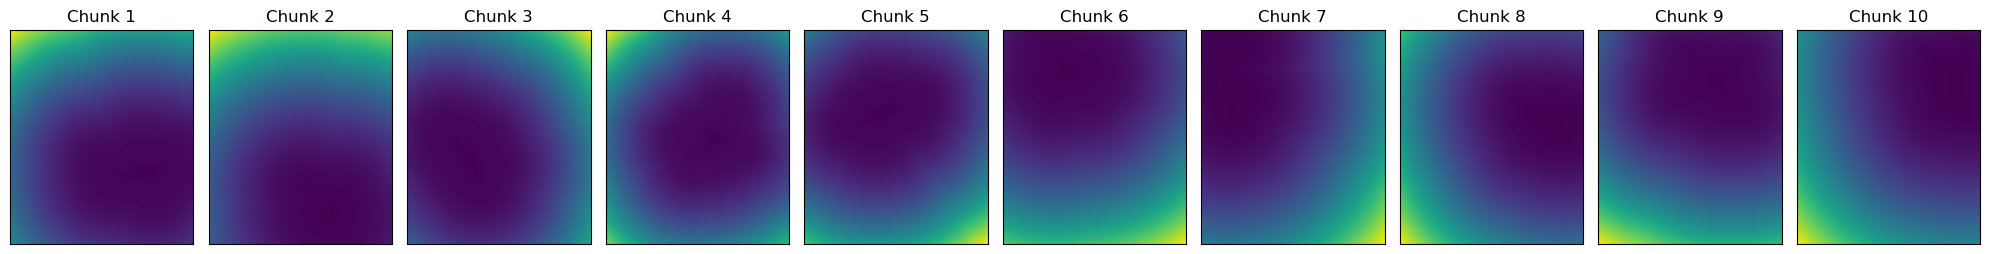

In [10]:
# To better understand, we'll reshape the distance map to 2D
# But numpy can handle these same operations without reshaping
dist_arr = np.reshape(dist_arr, (dist_arr.shape[0], chunk_mask_arr.shape[0], chunk_mask_arr.shape[1]))

f, ax = plt.subplots(1, len(chunk_ids), figsize=(20, 3))

for i, ax in enumerate(ax):
    ax.imshow(dist_arr[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Chunk {chunk_ids[i]}")

plt.tight_layout()
plt.show()
plt.show()


In [11]:
dist_map_all = np.argmin(dist_arr, axis = 0)

# Chunk IDs are 1-indexed whereas argmin returns 0-indexed
dist_map_all = chunk_ids[dist_map_all]

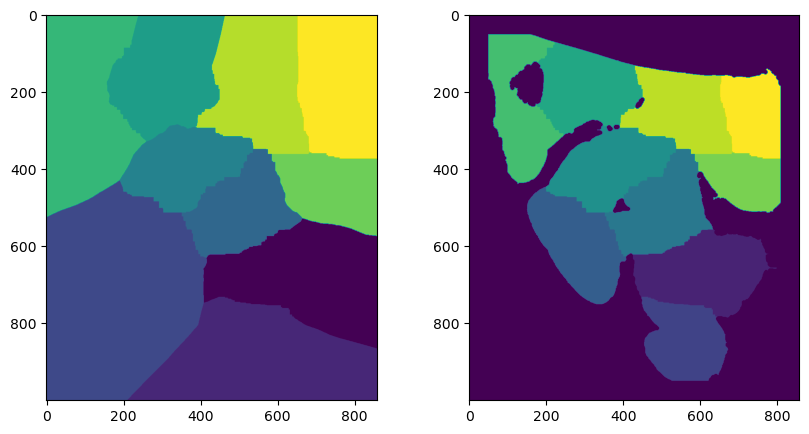

In [12]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(dist_map_all)
ax[1].imshow(chunk_mask_arr)
plt.show()

(1000, 858, 2)


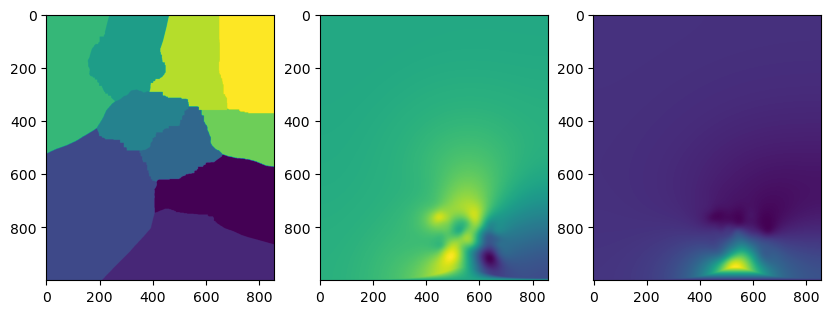

In [ ]:
# for k in chunk_ids:
k = 2
chunk_str = f"{k:02d}"
chunk_deformable = sitk.ReadImage(f"piecewise_deformable_{chunk_str}.nii.gz")

chunk_deformable_arr = sitk.GetArrayFromImage(chunk_deformable)

print(chunk_deformable_arr.shape)

f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(dist_map_all)
ax[1].imshow(chunk_deformable_arr[:,:,0]) # displacement in x direction
ax[2].imshow(chunk_deformable_arr[:,:,1]) # displacement in y direction
plt.show()